# Tarea 3 - Análisis del Modelo de Ising


Integrantes:

- Sara Sofía Rivera Sanabria.

- Juan Sebastián Rueda Segura.

- Santiago Rocha Pachón.

Considere el modelo de Ising en un *lattice* (rejilla) $K \times K$ con $10 \le K \le 20$.  
La distribución de Gibbs está dada por:

$$
\pi_\beta(\eta) = \frac{1}{Z_\beta} e^{-\beta H(\eta)}
$$

donde el Hamiltoniano (energía) es:

$$
H(\eta) = - \sum_{x \sim y} \eta_x \eta_y
$$

y $\beta \ge 0$ es el inverso de la temperatura.



## 1. Muestreo MCMC

Use un algoritmo MCMC (como Gibbs sampler o Metropolis–Hastings) para generar 100 muestras *aproximadas* del modelo de Ising.  

Las muestras deben ser los estados de la cadena en tiempos largos (ej., $(X_{10^3}), (X_{10^4}), (X_{10^5})$) para asegurar la convergencia a la distribución estacionaria.  

Realice esto para un rango de temperaturas inversas:

$$
\beta = \{0, 0.1, 0.2, 0.3, \ldots, 0.9, 1.0\}
$$


Pequeña interpretación: Imaginemos una red cuadrada donde en cada posición hay un pequeño imán que puede apuntar hacia arriba o hacia abajo. Estos imanes interactúan con sus vecinos inmediatos: prefieren alinearse en la misma dirección porque eso minimiza la energía del sistema. Sin embargo, la temperatura introduce aleatoriedad que puede desalinear los spins. A temperaturas bajas, los spins tienden a ordenarse todos en la misma dirección, pero a temperaturas altas, el desorden térmico domina y los spins apuntan aleatoriamente.

Numba es una biblioteca especial que compila funciones de Python a código máquina ultrarrápido, lo cual es esencial porque vamos a hacer millones de operaciones.

In [2]:
pip install numba tqdm matplotlib

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numba
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

La función recibe tres parámetros fundamentales: spin es la matriz que contiene nuestra rejilla de spins o sea los valores +1 o -1, L determina el tamaño de la rejilla L×L, y beta es la temperatura inversa.

Un barrido significa intentar voltear cada spin en promedio una vez. En cada iteración, seleccionamos aleatoriamente una posición (x, y) en la rejilla y guardamos el valor del spin en esa posición.

Luego calculamos la suma de los cuatro vecinos más cercanos del spin seleccionado. Esta suma R puede tomar valores entre -4 (todos los vecinos apuntan en dirección opuesta) y +4 (todos los vecinos apuntan en la misma dirección).

dH calcula el cambio de energía si volteamos el spin. Si R = 4 y el hamiltoneano es -1×4 = -4. Si volteamos el spin a -1, la nueva energía sería +1×4 = +4. El cambio es ΔH = 4 - (-4) = 8. La fórmula 2×s×R captura este cambio: 2×(+1)×4 = 8. El factor 2 aparece porque al voltear el spin de +s a -s, el cambio es 2s veces la suma de vecinos.

AHORA SI, el criterio de Metropolis-Hastings. Si voltear el spin disminuye la energía (dH < 0), siempre aceptamos el cambio porque el sistema naturalmente prefiere estados de menor energía. Si voltear el spin aumenta la energía (dH > 0), no rechazamos el cambio automáticamente. En su lugar, lo aceptamos con probabilidad $e^{-β ΔH}$. A temperaturas altas (β pequeño), esta probabilidad es grande y aceptamos muchos cambios desfavorables, ES DECIR, DESORDEN. A temperaturas bajas (β grande), la probabilidad es pequeña y raramente aceptamos cambios que aumentan la energía.

In [31]:
@numba.jit(nopython=True)
def _metropolis(spin, L, beta):
    """
    Realiza un barrido completo de metropolis-hastings sobre la rejilla.
    El spin será modificado al pasarlo por referencia.
    """
    for _ in range(L ** 2):
        x, y = random.randint(0, L - 1), random.randint(0, L - 1) #Obtener coordenadas
        s = spin[x, y]

        # Vecinos con condiciones periódicas,
        #la idea es que nuestra red no tiene bordes reales: si nos movemos más allá del borde derecho, aparecemos en el borde izquierdo, como en pac-man.
        # Esto elimina efectos de borde no deseados.
        xpp = (x + 1) if (x + 1) < L else 0 #pp es plus plus
        ypp = (y + 1) if (y + 1) < L else 0
        xnn = (x - 1) if (x - 1) >= 0 else (L - 1)
        ynn = (y - 1) if (y - 1) >= 0 else (L - 1)

        R = spin[xpp, y] + spin[x, ypp] + spin[xnn, y] + spin[x, ynn]
        dH = 2 * s * R

        if dH < 0:
            s = -s
        elif beta > 0 and np.random.rand() < np.exp(-beta * dH):
            s = -s

        spin[x, y] = s

Esta función calcula la energía total del sistema. Recorremos cada spin y sumamos su interacción con sus vecinos de derecha y abajo (de modo que se cuente cada arista una única vez, es decir, al ser un grafo no-dirigido, $(x, y) = (y, x)$ en $E$). La energía se divide por L² para obtener la energía promedio por spin.

In [14]:
@numba.jit(nopython=True)
def calc_energy(spin, L):
    """Calcula la energía promedio por spin"""
    energy = 0.0
    for i in range(L):
        for j in range(L):
            s = spin[i, j]
            right = spin[(i + 1) % L, j]
            down = spin[i, (j + 1) % L]
            energy += -s * (right + down)
    return energy / (L * L)

La magnetización es simplemente la suma de todos los spins dividida por el número total de spins. Si todos los spins apuntan hacia arriba (+1), la magnetización es +1. Si todos apuntan hacia abajo (-1), la magnetización es -1. Si hay igual cantidad de spins arriba y abajo, la magnetización es cero. Dividimos por L² para obtener la magnetización promedio por spin.

In [15]:
@numba.jit(nopython=True)
def calc_magnetization(spin, L):
    """Calcula la magnetización promedio por spin"""
    return np.sum(spin) / (L * L)

A continuación, un ejemplo del uso de las dos funciones.

In [103]:
spin = np.array([[1, 1, 1],
                [1, 1, 1],
                [1, 1, 1]])
L = 3
print(calc_energy(spin, L))
print(calc_magnetization(spin, L))

-2.0
1.0


Esta función genera una muestra del modelo de Ising corriendo una cadena de Markov por muchos pasos. La función np.random.randint(2, size=(K, K)) genera una matriz K×K de ceros y unos aleatorios. Al multiplicar por 2 obtenemos ceros y doses, y al restar 1 obtenemos -1 y +1, que son exactamente los valores que necesitamos para los spins.

Comenzamos con una configuración aleatoria. Luego aplicamos Metropolis-Hastings repetidamente. Cada aplicación realiza un barrido completo de la rejilla. Tras muchos barridos, el sistema "olvida" su configuración inicial y alcanza el equilibrio térmico a la temperatura especificada.


In [59]:
import os

def get_samples_mcmc(dimension: int, beta: float, mcmc_steps: int = 10000, m_and_e_calc: bool = True, file_path: str = None, n_samples: int = 100):
    """
    Computes `n_samples` samples of the Ising model with a
    `dimension` x `dimension` lattice and `beta` using the
    Metropolis-Hastings algorithm. It optionally stores the results
    in a csv with `file_path` name inside the folder `H3/results/`.

    Also, it will return the energy and magnetization of every
    configuration alongisde it if `m_and_e_calc` is True.

    Parameters
    ----------
    - dimension: int
        The square of the size of the lattice, i.e., it will have 
        `dimension` x `dimension` particles
    - beta: float
        The inverse of the temperature to compute the samples with.
    - m_and_e_calc: bool, optional
        If True, calculate the energy and magnetization of each
        configuration. Deafults to True
    - file_path: str, optional
        If provided, the results will be stored at
        `H3/results/file_path`. Defaults to None (don't save it)
    - n_samples: int
        Number of samples to compute. Defaults to 100

    Returns
    -------
    samples: pd.DataFrame
        A DataFrame containing at least a column of all the samples'
        configurations and if `m_and_e_calc` is set to True, two
        additional columns containing the energy and magnetization
        of each configuration.
    """

    data_list: list[np.ndarray] = []
    for _ in range(n_samples):
        config = 2 * np.random.randint(2, size=(dimension, dimension)) - 1
        for _ in range(mcmc_steps):
            _metropolis(config, dimension, beta)
        
        if m_and_e_calc:
            data_list.append([config, calc_energy(config, dimension), calc_magnetization(config, dimension)])
        else:
            data_list.append(config)

    columns: list[str] = ['config', 'energy', 'magnetization'] if m_and_e_calc else ['config']
    data_df: pd.DataFrame = pd.DataFrame(data_list, columns = columns)
    if file_path is not None:
        os.makedirs("H3/results", exist_ok=True)
        data_df.to_csv(f"H3/results/{file_path}")
        
    return data_df

In [60]:
get_samples_mcmc(dimension=3, beta=0.5, mcmc_steps=10000, n_samples = 1)

,config,energy,magnetization
0,"[[-1, -1, -1], [-1, -1, -1], [-1, -1, -1]]",-2.0,-1.0


Experimento con tamaños de red de 10 hasta 20, y temperaturas inversas de 0.0 a 1.0 en incrementos de 0.1. Este doble bucle anidado genera las 121 muestras (11 valores de K × 11 valores de β). Para cada combinación, generamos una muestra corriendo la cadena MCMC. Guardamos la magnetización en valor absoluto porque en el modelo de Ising hay una simetría: estados con todos los spins arriba y todos los spins abajo tienen la misma energía, así que el sistema puede estar en cualquiera de los dos estados ordenados.

In [83]:

def run_ising_experiment(K_range=(10, 21),
                        betas=None,
                        mcmc_steps=10000,
                        seed=42):
    """
    Ejecuta el experimento: UNA muestra por cada par (K, β).

    """
    if betas is None:
        betas = [round(i * 0.1, 1) for i in range(11)]  # 0.0, 0.1, ..., 1.0

    np.random.seed(seed)
    random.seed(seed)

    K_values = list(range(K_range[0], K_range[1]))

    print("="*70)
    print("EXPERIMENTO: MODELO DE ISING CON MCMC")
    print("="*70)
    print(f"Tamaños de red (K): {K_values[0]} a {K_values[-1]} → {len(K_values)} tamaños")
    print(f"Temperaturas inversas (β): {len(betas)} valores")
    print(f"Pasos MCMC por muestra: {mcmc_steps}")
    print(f"Total de muestras: {len(K_values)} × {len(betas)} = {len(K_values) * len(betas)}")
    print("="*70 + "\n")

    # Estructura de resultados sera dicc anidado
    results = {
        'K_values': K_values,
        'betas': betas,
        'energies': {},      # results['energies'][K][beta] = valor unico
        'magnetizations': {},  # magnetizations[K][beta] = valor unico
        'samples': {}        # samples[K][beta] = configuración única
    }

    for K in K_values: #inicializar vacios
        results['energies'][K] = {}
        results['magnetizations'][K] = {}
        results['samples'][K] = {}

    # Generar UNA muestra por cada (K, β)
    total_iterations = len(K_values) * len(betas)

    with tqdm(total=total_iterations, desc="Generando muestras") as pbar:
        for K in K_values:
            for beta in betas:
                # Correr cadena MCMC
                data_df = get_samples_mcmc(K, beta, mcmc_steps, n_samples=1)

                results['samples'][K][beta] = data_df.loc[0, 'config']
                results['energies'][K][beta] = data_df.loc[0, 'energy']
                results['magnetizations'][K][beta] = abs(data_df.loc[0, 'magnetization'])

                pbar.update(1)

    return results

In [84]:
results = run_ising_experiment(
    K_range=(10, 15),
    betas=None,
    mcmc_steps=10000,
    seed=42
)

EXPERIMENTO: MODELO DE ISING CON MCMC
Tamaños de red (K): 10 a 14 → 5 tamaños
Temperaturas inversas (β): 11 valores
Pasos MCMC por muestra: 10000
Total de muestras: 5 × 11 = 55



Generando muestras: 100%|██████████| 55/55 [00:04<00:00, 13.21it/s]


In [85]:
results['samples'][10]

{0.0: array([[-1, -1, -1, -1,  1,  1,  1,  1,  1, -1],
        [-1, -1, -1, -1,  1,  1,  1,  1,  1, -1],
        [-1, -1,  1,  1,  1,  1,  1,  1,  1, -1],
        [-1, -1,  1,  1,  1,  1,  1, -1, -1, -1],
        [-1, -1,  1,  1,  1,  1,  1, -1, -1, -1],
        [-1, -1, -1, -1, -1,  1,  1, -1, -1, -1],
        [-1, -1, -1, -1, -1,  1,  1, -1, -1, -1],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]),
 0.1: array([[ 1,  1,  1,  1, -1, -1, -1, -1,  1,  1],
        [ 1,  1,  1,  1,  1,  1, -1,  1, -1,  1],
        [ 1,  1, -1, -1, -1,  1, -1, -1, -1, -1],
        [-1,  1,  1, -1, -1,  1, -1,  1,  1, -1],
        [-1,  1,  1, -1, -1,  1, -1,  1, -1, -1],
        [-1,  1,  1, -1,  1, -1, -1, -1, -1, -1],
        [ 1, -1,  1, -1,  1,  1,  1,  1,  1, -1],
        [ 1, -1,  1,  1, -1,  1, -1, -1, -1, -1],
        [ 1, -1, -1,  1,  1,  1,  1, -1,  1,  1],
        [-1,  1, -1, -1,  1,  1,  1, -

Esta función crea dos figuras principales con valores extraidos de K y β de los resultados.

In [ ]:
def visualize_results(results):

    K_values = results['K_values']
    betas = results['betas']

    #  FIGURA 1: REJILLAS
    print("Configuraciones")
    print("-"*70)

    # Seleccionar 3 valores espaciados, el mas pequeño, el intermedio y el mas grande, PODRIAN SER MAS?
    K_indices = [0, len(K_values)//2, -1]
    K_selected = [K_values[i] for i in K_indices]

    # Seleccionar betas representativos (5 valores?)
    beta_indices = [0, len(betas)//4, len(betas)//2, 3*len(betas)//4, -1]
    betas_selected = [betas[i] for i in beta_indices]

    fig, axes = plt.subplots(len(K_selected), len(betas_selected),
                            figsize=(15, 9))

    for i, K in enumerate(K_selected):
        for j, beta in enumerate(betas_selected):
            sample = results['samples'][K][beta]

            axes[i, j].imshow(sample, cmap='RdBu', vmin=-1, vmax=1, interpolation='nearest') #ROJO+1 AZUL-1
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

            if i == 0:
                temp_str = f"β = {beta:.1f}"
                axes[i, j].set_title(temp_str, fontsize=12, fontweight='bold')

            if j == 0:
                axes[i, j].set_ylabel(f'K = {K}', fontsize=12, fontweight='bold', rotation=0, labelpad=30)

    plt.suptitle('Configuraciones del Modelo de Ising\n(Rojo: +1, Azul: -1)',
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

    # FIGURA 2: PROPIEDADES TERMODINÁMICAS
    print("\n Propiedades Termodinámicas")
    print("-"*70)

    # Preparar datos para mejor graficacion
    avg_energies = {}
    avg_mags = {}

    for K in K_values: #creamos listas que contienen la energía y magnetización para todos los valores de β
        avg_energies[K] = [results['energies'][K][beta] for beta in betas]
        avg_mags[K] = [results['magnetizations'][K][beta] for beta in betas]

    # convertir beta a temperatura T=1/beta
    temperatures = [1/b if b > 0 else 10 for b in betas]

    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    colors = plt.cm.viridis(np.linspace(0, 1, len(K_values)))

    # Magnetizacion vs beta
    ax = axes[0]
    for idx, K in enumerate(K_values):
        ax.plot(betas, avg_mags[K], 'o-', color=colors[idx],
                label=f'K={K}', markersize=5, linewidth=1.5, alpha=0.8)
    ax.set_xlabel('Temperatura inversa (β)', fontsize=12, fontweight='bold')
    ax.set_ylabel('|Magnetización|', fontsize=12, fontweight='bold')
    ax.set_title('Magnetización vs β', fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)

    # Energia vs T
    ax = axes[1]
    for idx, K in enumerate(K_values):
        ax.plot(temperatures[1:], avg_energies[K][1:], 'o-', color=colors[idx],
                label=f'K={K}', markersize=5, linewidth=1.5, alpha=0.8)
    ax.set_xlabel('Temperatura (T = 1/β)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Energía por spin', fontsize=12, fontweight='bold')
    ax.set_title('Energía vs Temperatura', fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 10])


    plt.tight_layout()
    plt.show()

EXPERIMENTO: MODELO DE ISING CON MCMC
Tamaños de red (K): 10 a 20 → 11 tamaños
Temperaturas inversas (β): 11 valores
Pasos MCMC por muestra: 10000
Total de muestras: 11 × 11 = 121



Generando muestras: 100%|██████████| 121/121 [00:17<00:00,  6.81it/s]


Configuraciones
----------------------------------------------------------------------


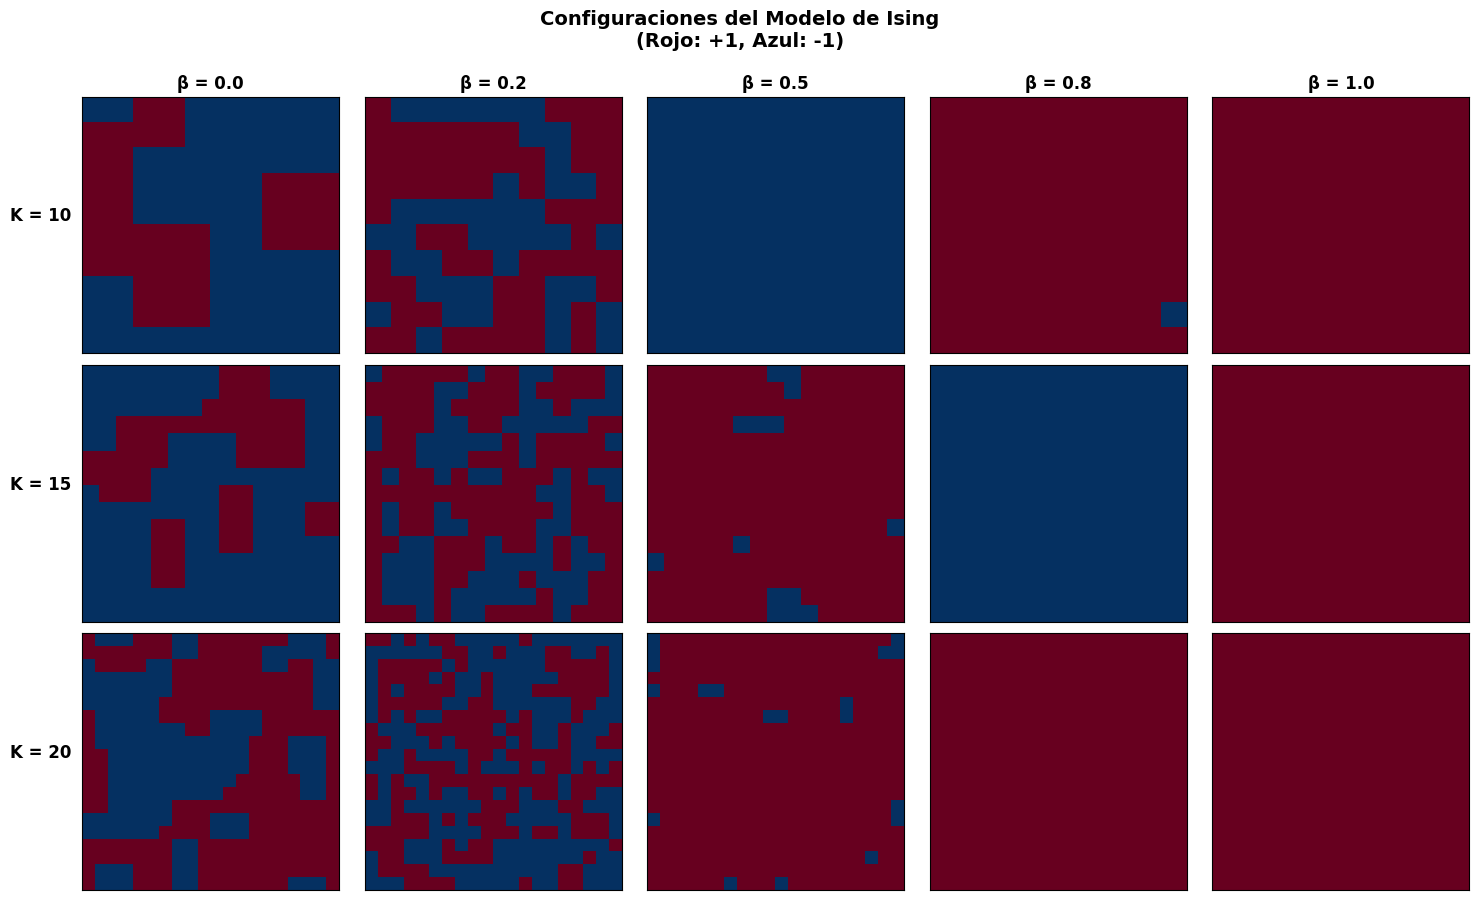


 Propiedades Termodinámicas
----------------------------------------------------------------------


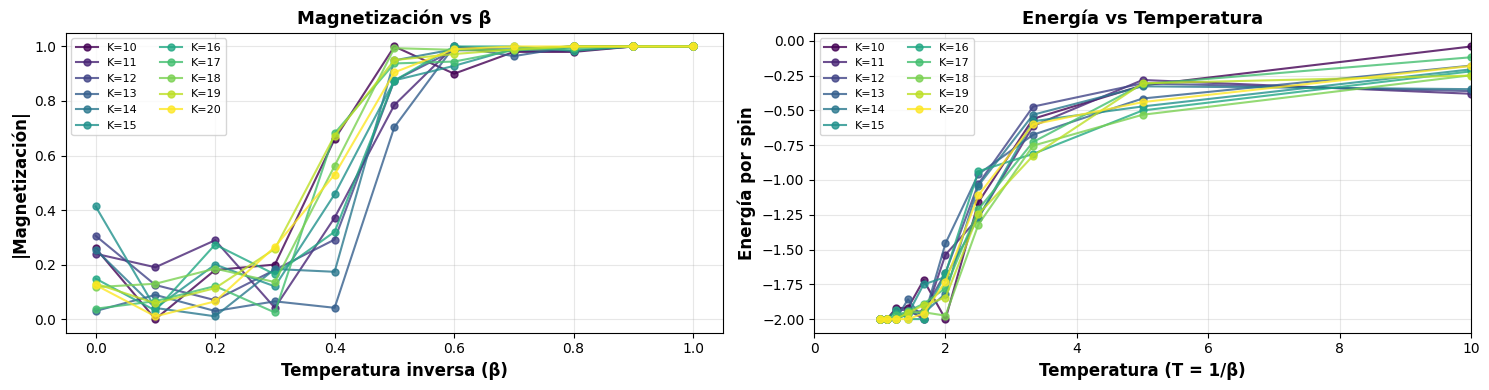

In [91]:
if __name__ == "__main__":
    results = run_ising_experiment(
        K_range=(10, 21),
        betas=[i * 0.1 for i in range(11)],
        mcmc_steps=10000,
        seed=42
    )


    visualize_results(results)

## 2. Muestreo Perfecto, Algoritmo Propp-Wilson

En el punto pasado utilizamos el Metrópolis-Hastings para generar muestras, pero en este caso debemos utilizar el Gibbs Sampler puesto que fue el que se comentó en clase al demostrarse que era monótono con la relación de orden que definiremos pronto. 

Recordemos la idea del Sandwiching: Si podemos introducir un orden parcial en el conjunto de estados $S$ y ese orden es respetado por la dinámica de la cadena, si corremos las cadenas que empiezan con las configuraciones maximal y minimal, garantizaramos la coalescencia de todos los estados posibles al estar siempre en medio de estos dos estados. Definamos pues el orden parcial entre los estados:

Dado $G = (V,E)$, sea $x' \in V$. Definimos la relación de orden entre los estados, dependiendo de $x'$ como:

$$
\xi \leq_{x'} \eta \iff \xi_x \leq \eta_x \forall x \neq x'
$$

Donde $\xi, \eta \in \{-1,1\}^V$ y $\xi_x \leq \eta_x \forall x \neq x'$ significa que los todas las entradas de la configuración $\xi$, exceptuando $x$, son menores que todas las correspondientes entradas de $\eta$.

Una vez definido el orden, creemos las clases auxiliares para poder comparar configuraciones y aplicar el muestreador de Gibbs rápidamente:


In [7]:
import numpy as np
import random
class Configuration:
    def __init__(self, beta, dimension):
        self.beta = beta
        self.dimension = dimension
        self.matrix = 2 * np.random.randint(2, size=(dimension, dimension)) - 1
        
    def k_plus(self, x, y):
        num = 0
        xpp = (x + 1) if (x + 1) < self.dimension else 0 #*right
        ypp = (y + 1) if (y + 1) < self.dimension else 0 #*up
        xnn = (x - 1) if (x - 1) >= 0 else (self.dimension - 1) #*left
        ynn = (y - 1) if (y - 1) >= 0 else (self.dimension - 1) #*down
        
        if self.matrix[xpp, y] == 1:
            num += 1
        if self.matrix[x, ypp] == 1:
            num += 1
        if self.matrix[xnn, y] == 1:
            num += 1
        if self.matrix[x, ynn] == 1:
            num += 1
        return num
    
    def k_minus(self, x, y):
        num = 0
        xpp = (x + 1) if (x + 1) < self.dimension else 0 #*right
        ypp = (y + 1) if (y + 1) < self.dimension else 0 #*up
        xnn = (x - 1) if (x - 1) >= 0 else (self.dimension - 1) #*left
        ynn = (y - 1) if (y - 1) >= 0 else (self.dimension - 1) #*down
        
        if self.matrix[xpp, y] == -1:
            num += 1
        if self.matrix[x, ypp] == -1:
            num += 1
        if self.matrix[xnn, y] == -1:
            num += 1
        if self.matrix[x, ynn] == -1:
            num += 1
        return num

    def gibbs_sampler_step_from(self, N, random_list):
        x,y = random_list.V_list[N]
        k_plus = self.k_plus(x, y)
        k_minus = self.k_minus(x, y)
        
        self.matrix[x, y] = 1 if random_list.U_list[N] < (np.exp(2*self.beta*(k_plus - k_minus)))/(np.exp(2*self.beta*(k_plus - k_minus)) + 1) else -1
 
    def __eq__(self, other: "Configuration"):
        return np.array_equal(self.matrix, other.matrix)
    
    # Método para comparar dos configuraciones excluyendo la posición x
    def is_leq_x(self, other: "Configuration", x: tuple) -> bool:
        for i in range(self.dimension):
            for j in range(self.dimension):
                if x[0] == i and x[1] == j:
                    continue
                if self.matrix[i, j] > other.matrix[i, j]:
                    return False
        return True
    

De acá cabe resaltar que para el Sampler estamos usando una lista de U_i's y de Vértices escogidos uniformemente del intervalo (0,1) y de los vértices de la matriz respectivamente. Crearemos una clase de lista aleatoria, ya que para cada paso vamos a necesitar guardar los U_i y V_i y a su vez generar 2^N_i - 2^N_{i-1} nuevos. Esto para poder aplicar los mismos números aleatorios sobre los mismos vértices en las cadenas de Markov. Una vez tenemos la estructura general de una configuración, heredamos de esta clase para construir las configuraciones minimales y maximales:

In [11]:
class RandomLists:
    def __init__(self):
        self.U_list = []
        self.V_list = []
    
    def extend(self, n_new, dimension):
        for _ in range(n_new):
            self.U_list.append(np.random.rand())
            x = random.randint(0, dimension - 1)
            y = random.randint(0, dimension - 1)
            self.V_list.append((x, y))

class MaximalConfiguration(Configuration):
    def __init__(self, beta, dimension):
        super().__init__(beta, dimension)
        self.matrix = np.ones((dimension, dimension), dtype=int)  # Inicializar con todos +1

class MinimalConfiguration(Configuration):
    def __init__(self, beta, dimension):
        super().__init__(beta, dimension)
        self.matrix = -1 * np.ones((dimension, dimension), dtype=int)  # Inicializar con todos -1

Ahora ya estamos en condiciones para correr el algoritmo Propp-Wilson y aplicar Sandwiching:

In [12]:
def propp_wilson_sandwiching(beta, dimension):
    N_j_minus_1 = 0
    N_j = 1
    random_list = RandomLists()
    max_config = MaximalConfiguration(beta, dimension)
    min_config = MinimalConfiguration(beta, dimension)

    #Vamos a correr hasta hallar el N_j tal que ambas cadenas X^{top}_{-N_j} y X^{bottom}_{-N_j} coalescan
    while True:
        random_list.extend(N_j - N_j_minus_1, dimension) # Añadimos los nuevos U_i y V_i necesarios para N_j - N_j_minus_1 iteraciones del sampler
        for i in range(N_j - 1, 0, -1):
            max_config.gibbs_sampler_step_from(i, random_list)
            min_config.gibbs_sampler_step_from(i, random_list)
            
            if max_config == min_config:
                return N_j - i, max_config.matrix # Ambas cadenas coalescieron en esta configuración

        #En N_j - N_j_minus_1 iteraciones no coalescieron, duplicamos N_j 
        N_j_minus_1 = N_j
        N_j *= 2
        max_config = MaximalConfiguration(beta, dimension)
        min_config = MinimalConfiguration(beta, dimension)
propp_wilson_sandwiching(beta=0.4, dimension=10)
    

(65536,
 array([[ 1,  1,  1,  1,  1,  1, -1,  1,  1,  1],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1,  1,  1,  1, -1,  1],
        [ 1,  1,  1,  1,  1, -1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1, -1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
        [ 1,  1,  1,  1, -1,  1,  1,  1,  1,  1]]))

Una vez con este código, podemos obtener las muestras requeridas para varios tamaños de rejillas

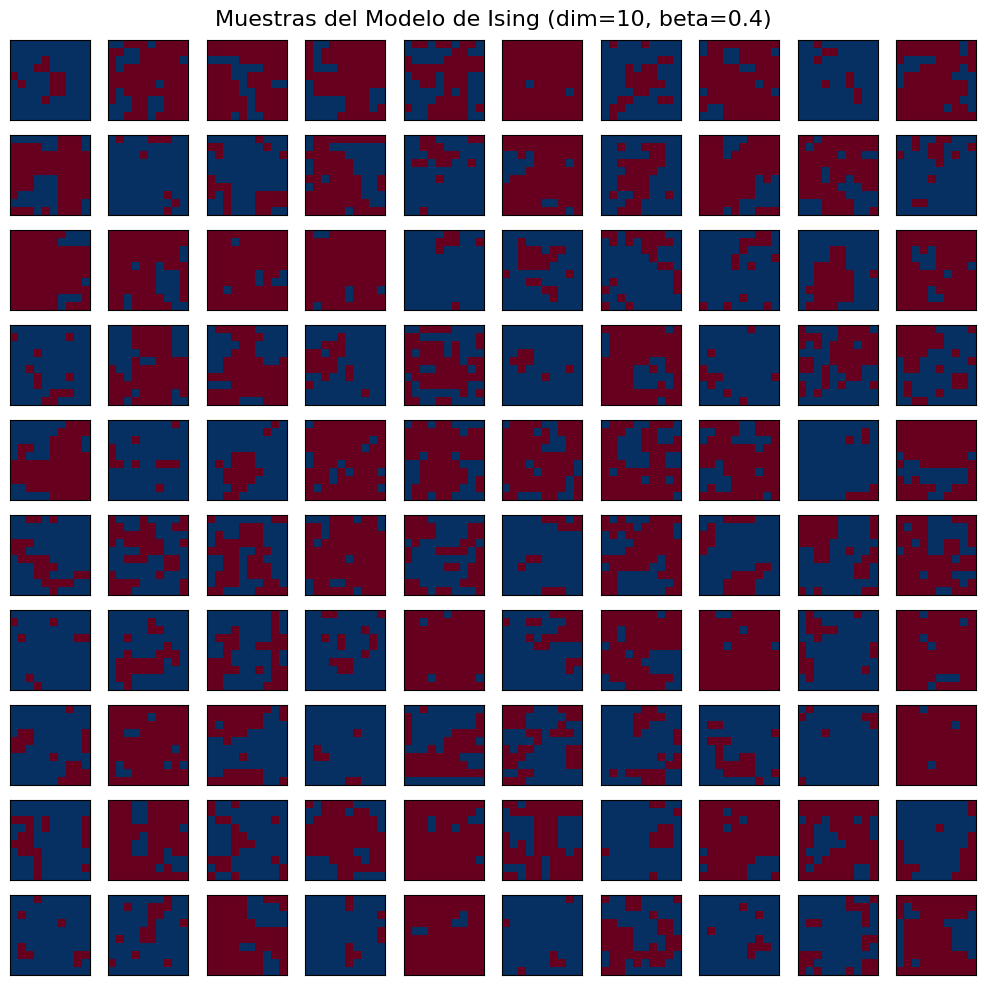

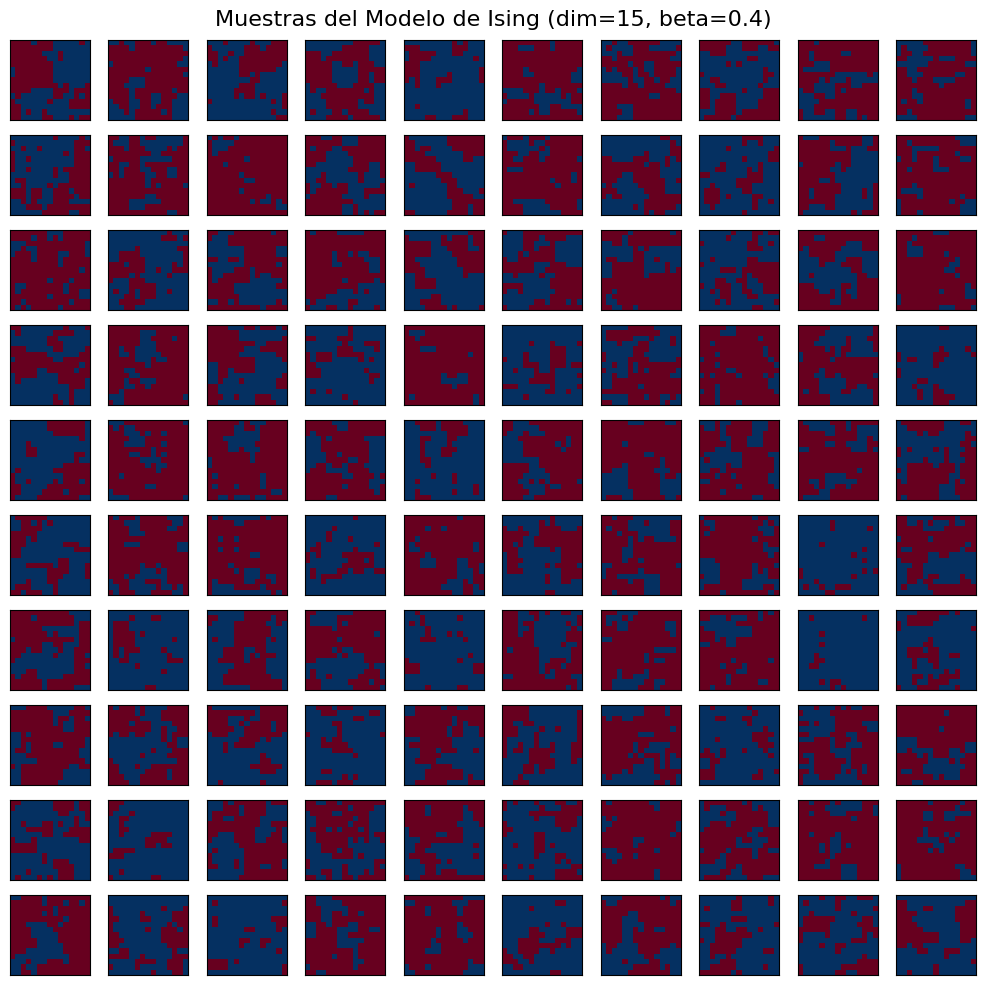

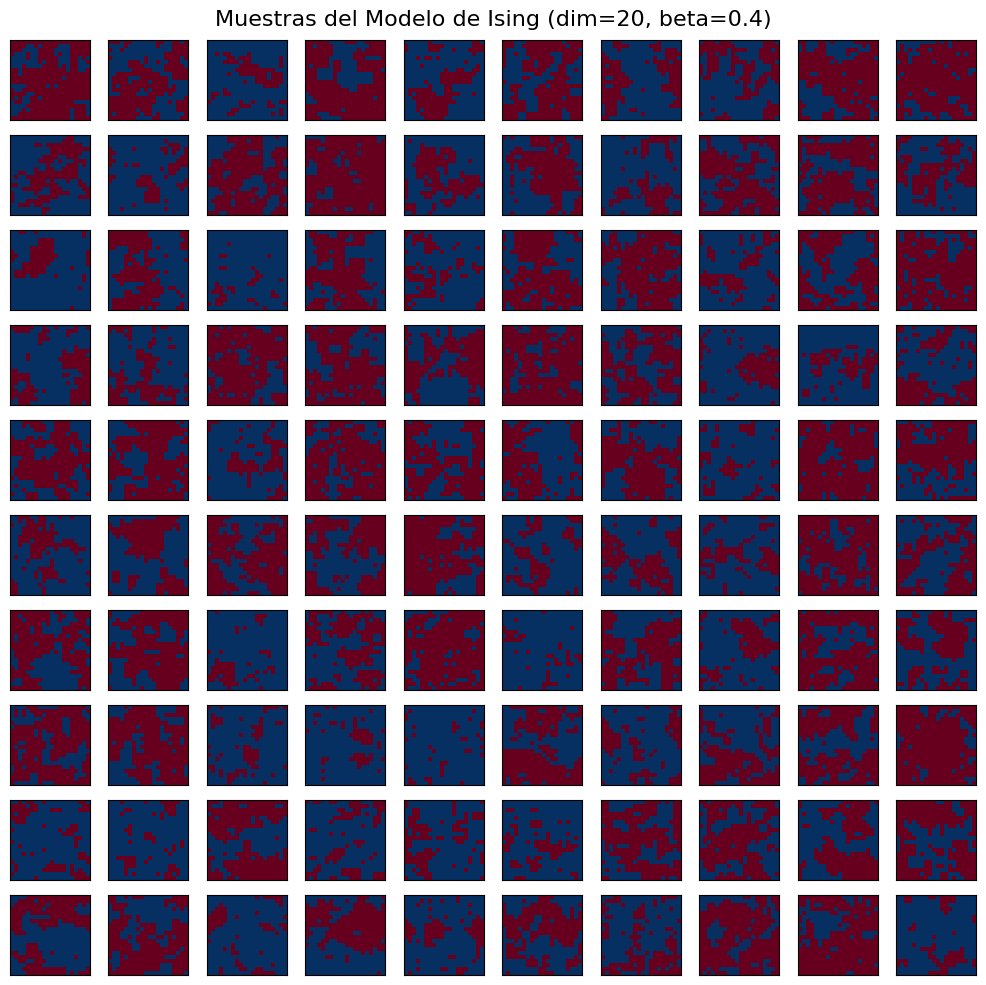

In [ ]:
import os

def get_samples_pw(beta: float, dimension: int, m_and_e_calc: bool = True, file_path: str = None, n_samples: int = 100):
    """
    Computes `n_samples` samples of the Ising model with a
    `dimension` x `dimension` lattice and `beta` using the Propp-Wilson
    algorithm (perfect simulation). It optionally stores the results in
    a csv with `file_path` name inside the folder `H3/results/`.

    Also, it will return the energy and magnetization of every
    configuration alongisde it if `m_and_e_calc` is True.

    Parameters
    ----------
    - beta: float
        The inverse of the temperature to compute the samples with.
    - dimension: int
        The square of the size of the lattice, i.e., it will have 
        `dimension` x `dimension` particles
    - m_and_e_calc: bool, optional
        If True, calculate the energy and magnetization of each
        configuration. Deafults to True
    - file_path: str, optional
        If provided, the results will be stored at
        `H3/results/file_path`. Defaults to None (don't save it)
    - n_samples: int
        Number of samples to compute. Defaults to 100

    Returns
    -------
    samples: pd.DataFrame
        A DataFrame containing at least a column of all the samples'
        configurations and if `m_and_e_calc` is set to True, two
        additional columns containing the energy and magnetization
        of each configuration.
    """
    data_list: list[np.ndarray] = []
    for _ in range(n_samples):
        N, config = propp_wilson_sandwiching(beta, dimension)
        if m_and_e_calc:
            data_list.append([config, calc_energy(config, dimension), calc_magnetization(config, dimension)])
        else:
            data_list.append(config)

    columns: list[str] = ['config', 'energy', 'magnetization'] if m_and_e_calc else ['config']
    data_df: pd.DataFrame = pd.DataFrame(data_list, columns = columns)
    if file_path is not None:
        os.makedirs("H3/results", exist_ok=True)
        data_df.to_csv(f"H3/results/{file_path}")
        
    return data_df

for dim in [10, 15, 20]:
    df = get_samples_pw(beta=0.4, dimension=dim, n_samples=100, file_path='test.csv')
    samples = df['config']
    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(10):
        for j in range(10):
            axes[i, j].imshow(samples.iloc[i*10 + j], cmap='RdBu', vmin=-1, vmax=1, interpolation='nearest')
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
    plt.suptitle(f'Muestras del Modelo de Ising (dim={dim}, beta=0.4)', fontsize=16)
    plt.tight_layout()
    plt.show()

## 3. Estimación de la magnetización

Estime el valor esperado de la magnetización, $E[M(\eta)]$, donde la magnetización de una configuración $\eta$ se define como:
$$
M(\eta) = \frac{1}{|V_K|} \sum_{x \in V_K} \eta_x
$$

(siendo $|V_K| = K^2$ el número de sitios). Realice esta estimación usando tanto las muestras aproximadas del ítem (a) como las muestras exactas del ítem (b).

El valor esperado de la magnetización es:
$$
E[M(\eta)] = \frac{1}{|V_k| \cdot Z_{G, \beta}} \cdot \sum_{\eta \in \{-1, +1\}^V} e^{-\beta H(\eta)} \cdot \sum_{x \in V_K} \eta_x
$$
donde $Z_{G, \beta} = \sum_{\eta \in \{-1, +1\}^V} e^{-\beta H(\eta)}$

Por lo tanto, una estimación del valor esperado se puede dar restringiendo la primera suma a las configuraciones muestreadas, es decir, si $X$ es el conjunto de todas las muestras, entonces
$$
E[M(\eta)] \approx \frac{1}{|V_k| \cdot \hat{Z}_{G, \beta}} \cdot \sum_{\eta \in X} e^{-\beta H(\eta)} \cdot \sum_{x \in V_K} \eta_x
$$
donde $\hat{Z}_{G. \beta} = \sum_{\eta \in X} e^{-\beta H(\eta)}$

In [ ]:
# def estimate_magnetization_ev(samples: int, k: int, beta: float, mcmc_steps: int = 100000) -> float:
#     energies_mcmc: list[float] = []
#     magnetizations_mcmc: list[float] = []
#     energies_exact: list[float] = []
#     magnetizations_exact: list[float] = []

#     for sample in range(samples):
#         spin, energy, magnetization = get_samples_mcmc(K=k, beta=beta, mcmc_steps=mcmc_steps, file_path=f'mcmc_{k}_{beta}')
#         energies_mcmc.append(energy)
#         magnetizations_mcmc.append(energy)
#         N_j, config = get_samples_pw(beta, dimension=k, )
#         energies_exact.append(calc_energy(config, k))
#         magnetizations_exact.append(calc_magnetization(config, k))

#     z_mcmc: float = np.array(energies_mcmc).sum()
#     z_exact: float = np.array(energies_exact).sum()
    
#     mag_mcmc: float = 0
#     for mag, energ in zip(magnetizations_mcmc, energies_mcmc):
#        mag_mcmc += (energ/z_mcmc)*mag

#     mag_exact: float = 0
#     for mag, energ in zip(magnetizations_exact, energies_exact):
#        mag_exact += (energ/z_exact)*mag

#     return mag_mcmc, mag_exact

In [116]:
estimate_magnetization_ev(100, 10, 0.3)

KeyboardInterrupt: 